# Imports

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import math

from digit_recognizer.utils import normalize_images
from digit_recognizer.resnet164 import ResNet164
from solver import solve

# Utils

In [590]:
def pre_process_image(img, skip_dilate=False, plot=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    # proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    _, proc = cv2.threshold(img.copy(),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc)

    # if not skip_dilate:
    #     # Dilate the image to increase the size of the grid lines.
    #     kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    #     proc = cv2.dilate(proc, kernel)
    
    if plot:
        plt.imshow(proc, cmap='gray')
        plt.title('pre_process_image')
        plt.show()
    return proc

def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image

    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

def distance_between(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def nearest_num_div_by_9(x, d = 9):
    return (x + d) - (x % d)

def crop(img, crop_rect, plot=False):
    top_left, bottom_right = crop_rect[0], crop_rect[2]

    x1, y1 = top_left
    x2, y2 = bottom_right

    crop = img[y1:y2, x1:x2]
    
    if plot:
        plt.imshow(crop, cmap='gray')
        plt.title('warp_image')
        plt.show()
    return crop

def crop_and_warp(img, original, crop_rect, plot=False):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
        ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    warp = cv2.warpPerspective(img, m, (int(side), int(side)))
    ori_wrap = cv2.warpPerspective(original, m, (int(side), int(side)))
    
    if plot:
        plt.imshow(warp, cmap='gray')
        plt.title('warp_image')
        plt.show()
        
    return warp, ori_wrap

In [387]:
def remove_whitelines(img, threshold = 0.3, plot=False):
    h, w = img.shape[:2]
    
    rows = []
    for row in range(img.shape[0]):
        if img[row,:].sum() > (h*255 * threshold):
            rows.append(row)

    cols = []
    for col in range(img.shape[1]):
        if img[:,col].sum() > (w*255 * threshold):
            cols.append(col)

    refined = np.delete(img, rows, 1)
    refined = np.delete(refined, cols, 0)

    if plot:
        plt.imshow(refined, cmap='gray')
        plt.title('refined_image')
        plt.show()
    
    return refined

def get_sudoku_puzzle(refined, prob_threshold = 0.4, corner_removal = 0.1):
    divisor = refined.shape[0]//9
    removal = int(divisor*corner_removal)
    
    puzzle = []
    for i in range(9):
        row = []
        for j in range(9):
            #slice image, reshape it to 28x28
            block = cv2.resize(refined[i*divisor:(i+1)*divisor,
                                        j*divisor:(j+1)*divisor][removal:-removal, removal:-removal], 
                                  dsize=(28,28), 
                                  interpolation=cv2.INTER_CUBIC)
            puzzle.append(block)
    puzzle = np.asarray(puzzle).reshape(81,28,28,1)
    
    puzzle_normalized = normalize_images(puzzle)
    preds = model.predict(puzzle_normalized, verbose=0)
    
    return ''.join([str(pred.argmax()) if pred[pred.argmax()] > prob_threshold else '.' for pred in preds])

def print_container(container):
    print("\n")
    for i in range(len(container)):
        line = ""
        if i == 3 or i == 6:
            print("------+-------+------")
        for j in range(len(container[i])):
            if j == 3 or j == 6:
                line += "| "
            line += str(container[i][j])+" "
        print(line)

In [412]:
def generate_image(ori_image, final, crop_rect, plot=False):
    
    top_left, bottom_right = crop_rect[0], crop_rect[2]
    (x1, y1), (x2, y2) = top_left, bottom_right
    
    image = ori_image[y1:y2, x1:x2]
    h_im, w_im = image.shape[:2]
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.4 * h_im/ 1024
    thickness = int(4 * h_im/1024)

    for y in range(9):
        for x in range(9):
            if final[y][x] == 0:
                continue
            true_y, true_x = int((y + 0.5) * h_im / 9), int((x + 0.5) * w_im / 9)
            digit = str(final[y, x])
            (text_width, text_height) = cv2.getTextSize(digit, font, fontScale= font_scale, thickness= thickness)[0]
            cv2.putText(image, digit,
                        (true_x - int(text_width / 2), true_y + int(text_height / 2)),
                         font, font_scale, (0, 0, 25), thickness * 2)
            cv2.putText(image, digit,
                        (true_x - int(text_width / 2), true_y + int(text_height / 2)),
                         font, font_scale, (100, 100, 200), thickness)
        
    return ori_image

In [589]:
def matrix_distance(m1, m2):
    return ((np.asarray(m1) - np.asarray(m2)) != 0).astype('int').sum()

def ai_sudoku_video(in_video_path, out_video_path, same_threshold = 5, similiar_threshold= 40, prob_threshold=0.6, corner_removal=0.1, refined_threshold=0.2):
    cap = cv2.VideoCapture(in_video_path)
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
    print(frame_rate)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height =int(cap.get( cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(out_video_path, fourcc, frame_rate, (frame_height, frame_width))

    old_sudoku_puzzle_mat = np.asarray([10]*81).reshape(9,9)
    old_final = np.asarray([' ']*81).reshape(9,9)
    
    i = 0
    while(True):
        ret, frame = cap.read()
        if not ret:
            break
        i += 1
        frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
#         try:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        processed = pre_process_image(gray, plot = False)

        crop_rect = find_corners_of_largest_polygon(processed)
        cropped, ori_cropped = crop_and_warp(processed, img, crop_rect, plot = False)

        refined = remove_whitelines(cropped, threshold=refined_threshold, plot = False)

        sudoku_puzzle = get_sudoku_puzzle(refined, prob_threshold = prob_threshold, corner_removal=corner_removal)
#         print(sudoku_puzzle)
        sudoku_puzzle_mat = np.asarray([int(num) if num!='.' else 0 for num in sudoku_puzzle]).reshape(9,9)

        if matrix_distance(sudoku_puzzle_mat, old_sudoku_puzzle_mat) < same_threshold:
            final_image = generate_image(frame, old_final, crop_rect, plot = False)
        else:
            solved = solve(sudoku_puzzle)        
            if solved is not False:
                solved = np.array(list(map(int,(solved.values())))).reshape(9,9)
                final = solved.astype('int') - sudoku_puzzle_mat.astype('int')
                final_image = generate_image(frame, final, crop_rect, plot = False)
    
                old_final = final
                
            elif matrix_distance(sudoku_puzzle_mat, old_sudoku_puzzle_mat) < similiar_threshold:
                final_image = generate_image(frame, old_final, crop_rect, plot = False)
        
#         print(f'{matrix_distance(sudoku_puzzle_mat, old_sudoku_puzzle_mat)}')
        
        old_sudoku_puzzle_mat = sudoku_puzzle_mat
#         except:
#             pass
        out.write(frame)

    cap.release()
    out.release()

# Digit Model Load

In [350]:
model = ResNet164()
model.compile()

model.load_weights('digit_recognizer/models/ResNet164.h5')

# Testing the code

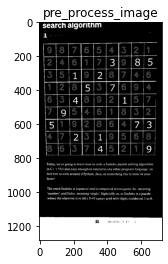

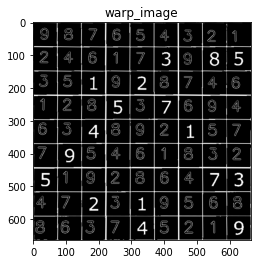

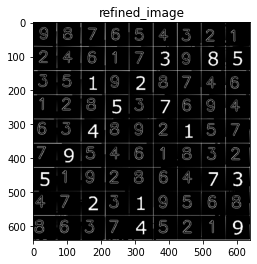



8 8 8 | 8 5 4 | 3 2 8 
2 4 8 | 8 8 3 | 8 8 5 
3 5 1 | 8 2 8 | 8 4 8 
------+-------+------
8 2 8 | 5 3 7 | 8 8 4 
8 3 4 | 8 8 2 | 1 8 8 
8 9 5 | 4 8 . | 8 3 2 
------+-------+------
5 8 8 | 2 8 8 | 4 7 3 
2 8 2 | 3 1 8 | 5 8 8 
8 8 3 | 8 4 5 | 2 8 9 
Couldnt solve


In [458]:
img = frame#cv2.imread('test_images/test1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

processed = pre_process_image(gray, plot = True)

crop_rect = find_corners_of_largest_polygon(processed)
cropped, ori_cropped = crop_and_warp(processed, img, crop_rect, plot = True)

refined = remove_whitelines(cropped, threshold=0.4, plot = True)

sudoku_puzzle = get_sudoku_puzzle(refined, prob_threshold = 0.5, corner_removal=0.1)
sudoku_puzzle_mat = np.asarray([int(num) if num!='.' else '.' for num in sudoku_puzzle]).reshape(9,9)
print_container(sudoku_puzzle_mat)

solved = solve(sudoku_puzzle)

if solved is not False:
    solved = np.array(list(map(int,(solved.values())))).reshape(9,9)
    print_container(solved)

    sudoku_puzzle_mat[sudoku_puzzle_mat == '.'] = 0
    final = solved.astype('int') - sudoku_puzzle_mat.astype('int')

    final_image = generate_image(img, final, crop_rect)
else:
    print('Couldnt solve')

# Image

In [586]:
def ai_sudoku_image(image):
    if type(image) ==str:
        img = cv2.imread(image)
    else:
        img = image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    processed = pre_process_image(gray, plot = False)

    crop_rect = find_corners_of_largest_polygon(processed)
    cropped, ori_cropped = crop_and_warp(processed, img, crop_rect, plot = False)

    refined = remove_whitelines(cropped, threshold=0.3, plot = False)

    sudoku_puzzle = get_sudoku_puzzle(refined, prob_threshold = 0.5, corner_removal=0.1)
    sudoku_puzzle_mat = np.asarray([int(num) if num!='.' else '.' for num in sudoku_puzzle]).reshape(9,9)

    solved = solve(sudoku_puzzle)

    if solved is not False:
        solved = np.array(list(map(int,(solved.values())))).reshape(9,9)

        sudoku_puzzle_mat[sudoku_puzzle_mat == '.'] = 0
        final = solved.astype('int') - sudoku_puzzle_mat.astype('int')

        final_image = generate_image(img, final, crop_rect, plot = False)
        return final_image
    else:
        print('Couldnt solve')

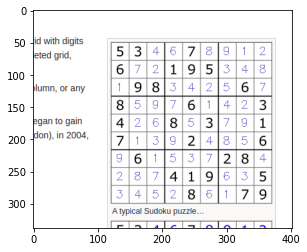

In [588]:
plt.imshow(ai_sudoku_image('test_images/test1.png'))

# Video

In [585]:
ai_sudoku_video('test_videos/vid5.mp4', 'test_videos/output5_30.avi',
                same_threshold = 10, similiar_threshold= 40, 
                 refined_threshold=0.3, prob_threshold=0.7, corner_removal=0.1)

30


# Scrap

In [59]:
hardest_sudoku = [
    [8,0,0,0,0,0,0,0,0],
    [0,0,3,6,0,0,0,0,0],
    [0,7,0,0,9,0,2,0,0],
    [0,5,0,0,0,7,0,0,0],
    [0,0,0,0,4,5,7,0,0],
    [0,0,0,1,0,0,0,3,0],
    [0,0,1,0,0,0,0,6,8],
    [0,0,8,5,0,0,0,1,0],
    [0,9,0,0,0,0,4,0,0]]

hardest = ''.join(list(map(str, np.array(hardest_sudoku).reshape(-1)))).replace('0','.')
''.join(solve(hardest).values())

'812753649943682175675491283154237896369845721287169534521974368438526917796318452'